# Preprocessing Notebook

## План по предобработке:
### 1. Заполнить пропуски в данных (BayesianRidge)
### 2. Поработать с выбросами (winsorizing)
### 3. Устранить скошенность вправо (log1p)
### 4. Отмасштабировать признаки (MinMaxScaler/StandardScaler)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

-----------

In [5]:
train_df = pd.read_csv("../Data/cs-training.csv")
test_df = pd.read_csv("../Data/cs-test.csv")

In [6]:
X = train_df.drop(["SeriousDlqin2yrs","Unnamed: 0"], axis=1)
y = train_df["SeriousDlqin2yrs"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [7]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
138985,0.000000,49,0,0.127227,5163.0,5,0,0,0,0.0
63964,0.033105,37,0,0.423063,2800.0,4,0,1,0,1.0
46077,0.007948,39,0,0.685663,3333.0,11,0,1,0,0.0
83030,0.576297,57,0,0.320077,15161.0,14,0,4,0,0.0
11184,0.623724,35,0,0.534226,6500.0,9,0,3,0,1.0


In [8]:
X_train.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           20723
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2721
dtype: int64

## Определим важные фичи для заполнения пропусков в `MonthlyIncome`

NumberOfTime60-89DaysPastDueNotWorse    0.001156
NumberOfTimes90DaysLate                 0.001781
NumberOfDependents                      0.013457
NumberOfTime30-59DaysPastDueNotWorse    0.016080
NumberOfOpenCreditLinesAndLoans         0.027644
age                                     0.032858
NumberRealEstateLoansOrLines            0.035592
RevolvingUtilizationOfUnsecuredLines    0.199595
DebtRatio                               0.671839
dtype: float64


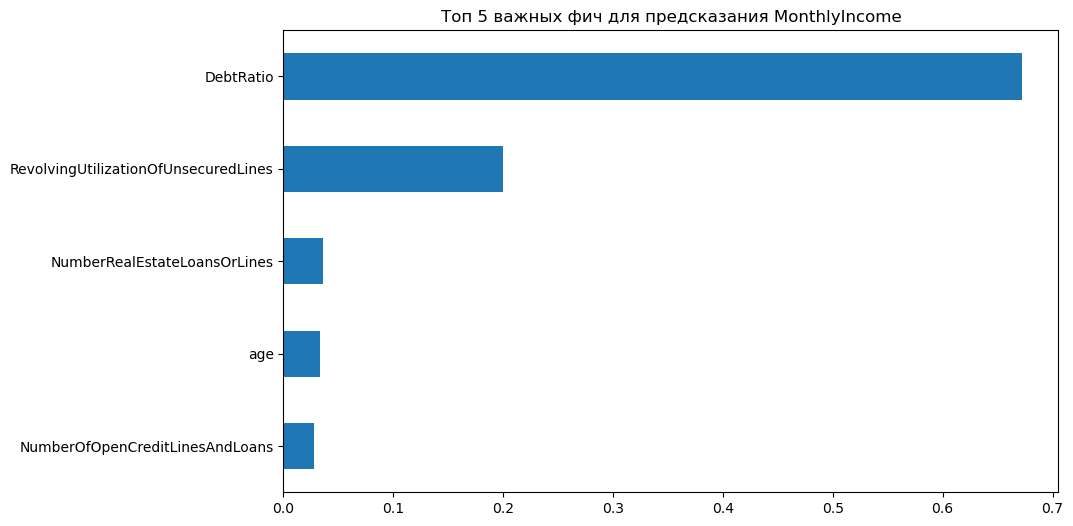

In [10]:
MI_known = X_train[X_train["MonthlyIncome"].notna()]

X_for_tree = MI_known.drop("MonthlyIncome", axis=1) 
y_for_tree = MI_known["MonthlyIncome"]              

X_for_tree_filled = X_for_tree.fillna(X_for_tree.mean()) 

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_for_tree_filled, y_for_tree)

feature_importances = pd.Series(dt.feature_importances_, index=X_for_tree_filled.columns)
important_features = feature_importances.sort_values()

print(important_features)

plt.figure(figsize=(10, 6))
important_features.tail(5).plot(kind='barh')
plt.title('Топ 5 важных фич для предсказания MonthlyIncome')
plt.show()


## Аналогичным образом определим важность признаков для заполнения пропусков в `NumberOfDependents`

NumberOfTime60-89DaysPastDueNotWorse    0.010042
NumberOfTimes90DaysLate                 0.012246
NumberOfTime30-59DaysPastDueNotWorse    0.023135
NumberRealEstateLoansOrLines            0.033775
NumberOfOpenCreditLinesAndLoans         0.096787
RevolvingUtilizationOfUnsecuredLines    0.186028
age                                     0.205857
DebtRatio                               0.214736
MonthlyIncome                           0.217395
dtype: float64


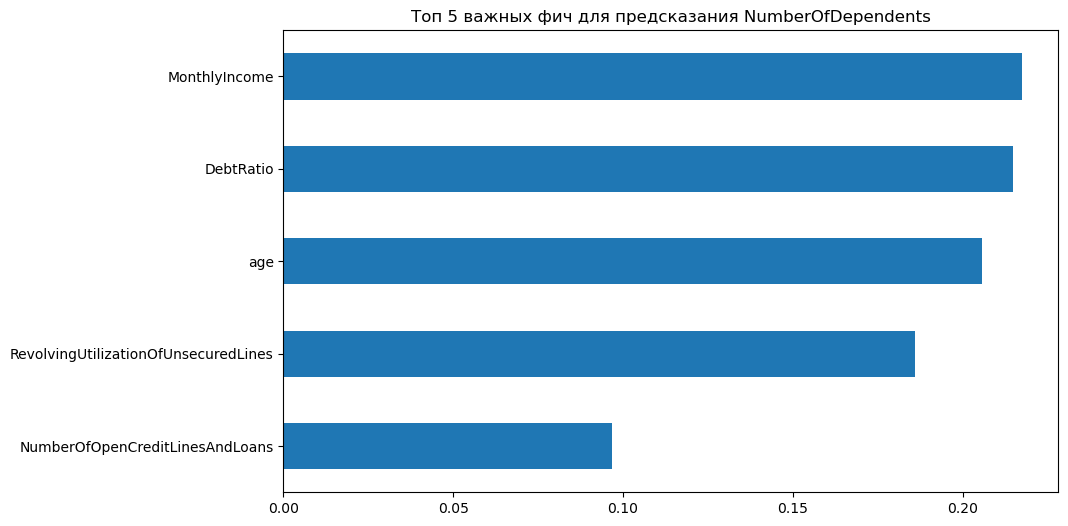

In [12]:
ND_known = X_train[X_train["NumberOfDependents"].notna()]

X_for_tree = ND_known.drop("NumberOfDependents", axis=1) 
y_for_tree = ND_known["NumberOfDependents"]              

X_for_tree_filled = X_for_tree.fillna(X_for_tree.mean()) 

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_for_tree_filled, y_for_tree)

feature_importances = pd.Series(dt.feature_importances_, index=X_for_tree_filled.columns)
important_features = feature_importances.sort_values()

print(important_features)

plt.figure(figsize=(10, 6))
important_features.tail(5).plot(kind='barh')
plt.title('Топ 5 важных фич для предсказания NumberOfDependents')
plt.show()


## Опираясь на полученную информацию, попробуем с помощью BayesianRidge заполнить пропуски сначала в `MonthlyIncome`, т.к. он полезен при заполнении другого признака, а потом уже и сам столбец `NumberOfDependents`

In [14]:
target_col = 'MonthlyIncome'
predictor_cols = ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines', 'NumberRealEstateLoansOrLines']

X_train_imputed = X_train.copy()
X_val_imputed = X_val.copy()

train_missing_mask = X_train[target_col].isna()
train_known_data = X_train[~train_missing_mask]
train_unknown_data = X_train[train_missing_mask]

val_missing_mask = X_val[target_col].isna()
val_unknown_data = X_val[val_missing_mask]


model = BayesianRidge()
model.fit(train_known_data[predictor_cols], train_known_data[target_col])

predictions = model.predict(train_unknown_data[predictor_cols])
predictions = np.maximum(predictions, 0) 
X_train_imputed.loc[train_missing_mask, target_col] = predictions

predictions = model.predict(val_unknown_data[predictor_cols])
predictions = np.maximum(predictions, 0)
X_val_imputed.loc[val_missing_mask, target_col] = predictions

In [15]:
joblib.dump(model, '../models/bayesian_mi.joblib')

['../models/bayesian_mi.joblib']

In [16]:
target_col = 'NumberOfDependents'
predictor_cols = ['MonthlyIncome', 'DebtRatio', 'age', 'RevolvingUtilizationOfUnsecuredLines', 'NumberOfOpenCreditLinesAndLoans']

train_missing_mask = X_train_imputed[target_col].isna()
train_known_data = X_train_imputed[~train_missing_mask]
train_unknown_data = X_train_imputed[train_missing_mask]

val_missing_mask = X_val_imputed[target_col].isna()
val_unknown_data = X_val_imputed[val_missing_mask]

model = BayesianRidge()
model.fit(train_known_data[predictor_cols], train_known_data[target_col])

predictions_int = model.predict(train_unknown_data[predictor_cols])
predictions_int = np.maximum(predictions_int, 0)
predictions_int = np.round(predictions_int)
X_train_imputed.loc[train_missing_mask, target_col] = predictions_int

predictions_int = model.predict(val_unknown_data[predictor_cols])
predictions_int = np.maximum(predictions_int, 0)
predictions_int = np.round(predictions_int) 
X_val_imputed.loc[val_missing_mask, target_col] = predictions_int

In [17]:
joblib.dump(model, '../models/bayesian_nd.joblib')

['../models/bayesian_nd.joblib']

## Конечно, можно сделать проще, но есть нюанс: здесь не учитывается тот факт, что наши признаки неотрицательны, а `NumberOfDependents` еще и целочисленный, поэтому, с точки зрения здравого смысла, стоит использовать первоначальный подход, но насколько он эффективнее, или, наоборот, хуже?

In [19]:
BayesianR_Imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10000,
    random_state=42
)

X_train_imputed_iter = pd.DataFrame(BayesianR_Imputer.fit_transform(X_train), columns=X_train.columns)
X_val_imputed_iter =  pd.DataFrame(BayesianR_Imputer.transform(X_val), columns=X_val.columns)

In [20]:
X_train_imputed.isna().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

## Посмотрим на характеристики признаков до и после заполнения пропусков

In [22]:
X_train[['MonthlyIncome','NumberOfDependents']].describe().round(2)

,MonthlyIncome,NumberOfDependents
count,84277.00,102279.00
mean,6613.05,0.76
std,11166.67,1.11
min,0.00,0.00
25%,3400.00,0.00
50%,5382.00,0.00
75%,8227.00,1.00
max,1794060.00,13.00


In [23]:
X_train_imputed[['MonthlyIncome','NumberOfDependents']].describe().round(2)

,MonthlyIncome,NumberOfDependents
count,105000.00,105000.00
mean,6036.08,0.75
std,10098.20,1.10
min,0.00,0.00
25%,3265.37,0.00
50%,4963.48,0.00
75%,7396.00,1.00
max,1794060.00,13.00


In [24]:
X_train_imputed_iter[['MonthlyIncome','NumberOfDependents']].describe().round(2)

,MonthlyIncome,NumberOfDependents
count,105000.00,105000.00
mean,5908.85,0.75
std,10719.86,1.10
min,-584584.18,-1.64
25%,3100.00,0.00
50%,4847.97,0.00
75%,7400.00,1.00
max,1794060.00,13.00


### Можно заметить характерные минимальные значения -584584 и -1.64 для наших неотрицательных признаков

### Быстро сравним эффективность обоих подходов

In [27]:
LR_man = LogisticRegression(max_iter=5000, class_weight='balanced')
LR_iter = LogisticRegression(max_iter=5000, class_weight='balanced')


LR_man.fit(X_train_imputed,y_train)
LR_iter.fit(X_train_imputed_iter,y_train)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [28]:
y_pred_man = LR_man.predict(X_val_imputed)
y_pred_iter = LR_iter.predict(X_val_imputed_iter)

roc_auc_score(y_val, y_pred_man), roc_auc_score(y_val, y_pred_iter)

(0.7224224953689254, 0.721863339977625)

## Благодаря ручному подходу удается добиться чуть лучшего результата по сравнению с обычным IterativeImputer
0.7224 > 0.7218

------------------------

# После обработки пропусков можно приступить к преобразованиям признаков

## 1. Избавимся от мультиколлинеарности:

In [33]:
X_train_proc = X_train_imputed.copy()
X_val_proc = X_val_imputed.copy()


# Агрегируем коррелирующие признаки
X_train_proc['PastDueAggregated'] = (
    X_train_proc['NumberOfTime30-59DaysPastDueNotWorse'] +
    X_train_proc['NumberOfTime60-89DaysPastDueNotWorse'] +
    X_train_proc['NumberOfTimes90DaysLate']
)

X_val_proc['PastDueAggregated'] = (
    X_val_proc['NumberOfTime30-59DaysPastDueNotWorse'] +
    X_val_proc['NumberOfTime60-89DaysPastDueNotWorse'] +
    X_val_proc['NumberOfTimes90DaysLate']
)


correlation_cols = ['NumberOfTime30-59DaysPastDueNotWorse',
                    'NumberOfTime60-89DaysPastDueNotWorse',
                    'NumberOfTimes90DaysLate',
                    'PastDueAggregated']

corr_matrix = X_train_proc[correlation_cols].corr()

# Удаляем исходные признаки
X_train_proc = X_train_proc.drop([
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate'
], axis=1)

X_val_proc = X_val_proc.drop([
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate'
], axis=1)

X_train_proc.shape

(105000, 8)

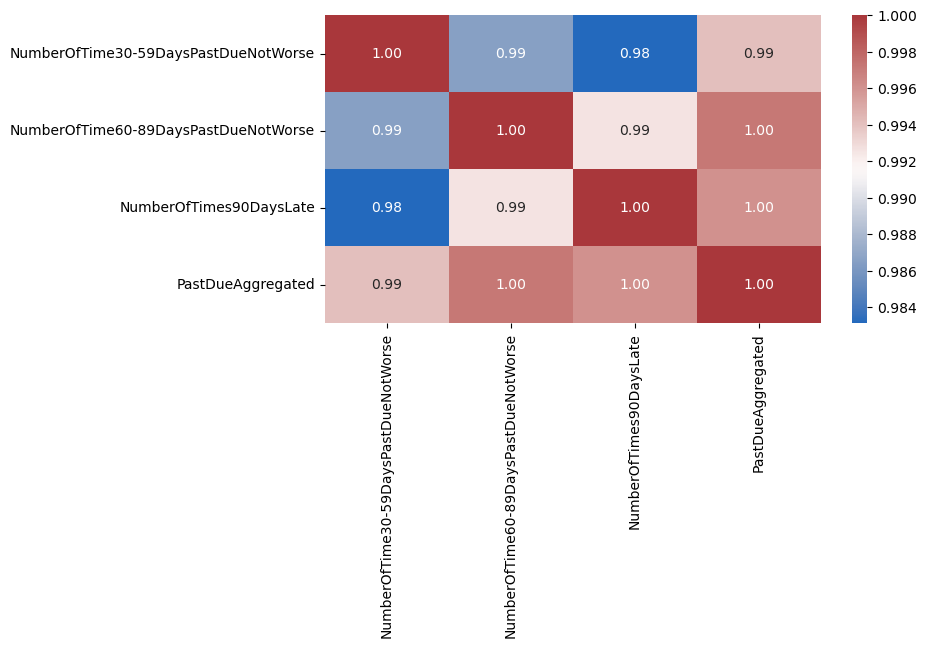

In [34]:
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, cmap="vlag" , annot=True, fmt="0.2f");

## 2. Клипнем признаки

In [36]:
X_train_clip = X_train_proc.copy()
X_val_clip = X_val_proc.copy()

q = 0.95

for col in X_train_proc.columns:
    upper_train = X_train_proc[col].quantile(q)
    upper_val = X_val_proc[col].quantile(q)

    X_train_clip[col] = X_train_proc[col].clip(0, upper_train)
    X_val_clip[col] = X_val_proc[col].clip(0,upper_val)


<Figure size 800x400 with 0 Axes>

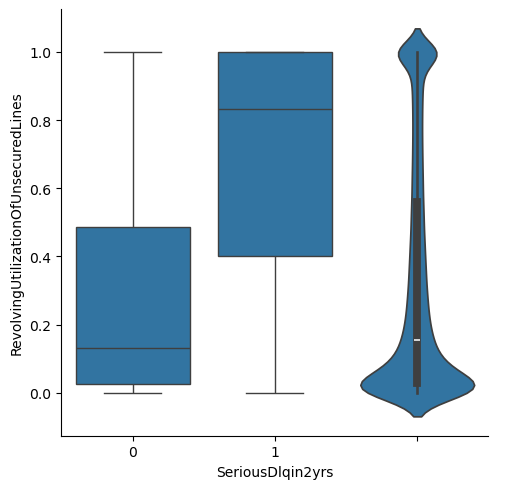

<Figure size 800x400 with 0 Axes>

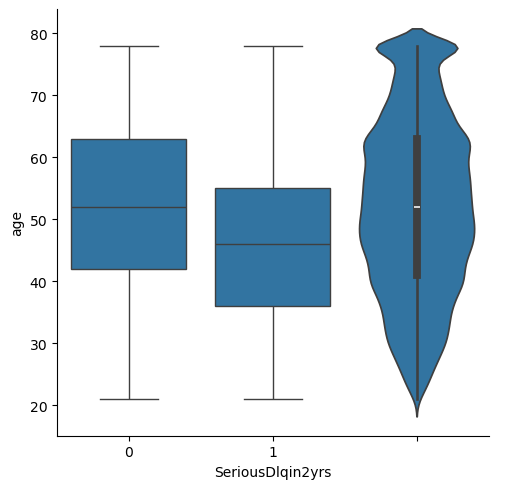

<Figure size 800x400 with 0 Axes>

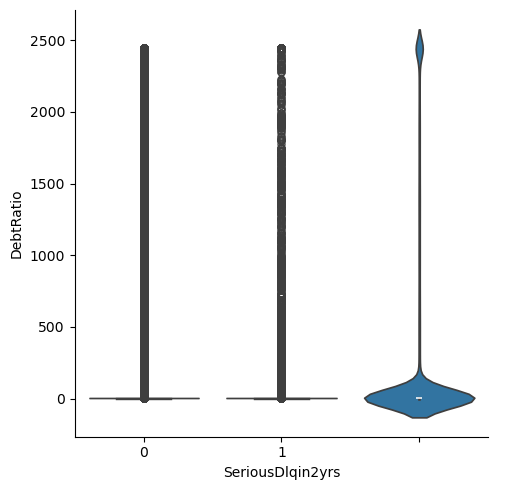

<Figure size 800x400 with 0 Axes>

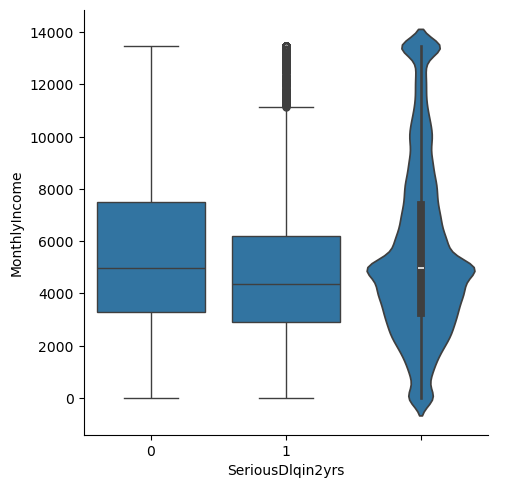

<Figure size 800x400 with 0 Axes>

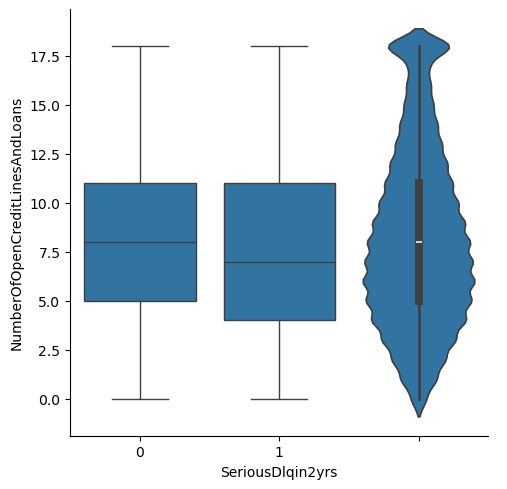

<Figure size 800x400 with 0 Axes>

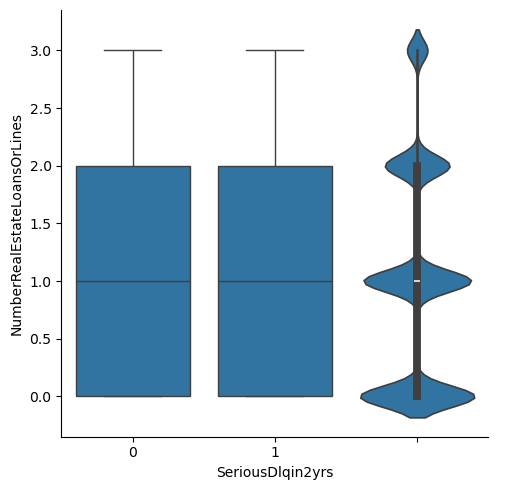

<Figure size 800x400 with 0 Axes>

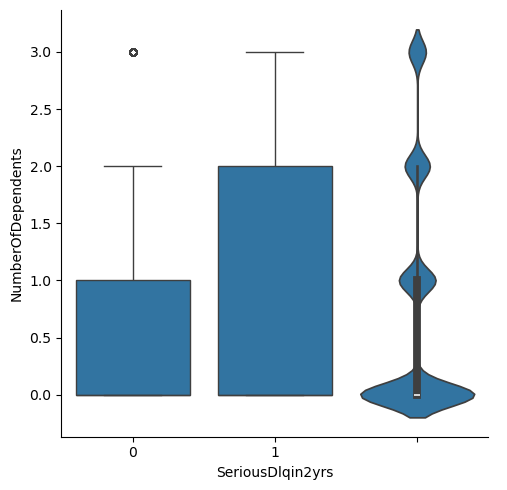

<Figure size 800x400 with 0 Axes>

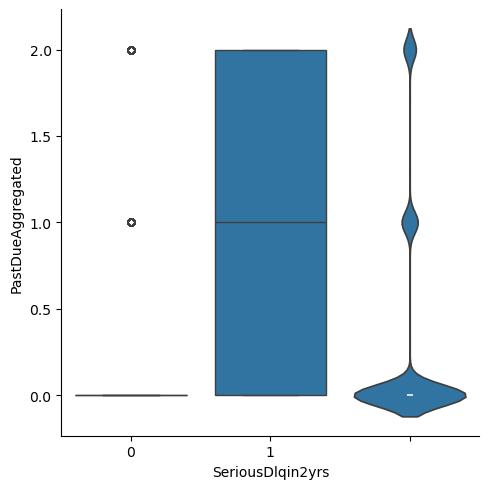

In [37]:
for c in X_train_clip.columns:
    plt.figure(figsize=(8, 4))
    sns.catplot(x=y_train, y=c, data=X_train_clip, kind="box")
   
    sns.violinplot(X_train_clip[c])
    plt.show()


### Благодаря клиппингу сильная скошенность вправо исчезла у большинства признаков

## 3. Избавимся от скошенности вправо с помощью логарифмического преобразования

In [39]:
skewness_info = []
for col in X_train_clip.columns:
    skew_val = X_train_clip[col].skew()
    skewness_info.append({
        'Признак': col,
        'Скошенность': skew_val,
    })

skewness_df = pd.DataFrame(skewness_info).sort_values('Скошенность', ascending=False)
print(skewness_df.to_string())

                                Признак  Скошенность
2                             DebtRatio     2.559864
7                     PastDueAggregated     1.951583
6                    NumberOfDependents     1.125458
0  RevolvingUtilizationOfUnsecuredLines     0.888026
3                         MonthlyIncome     0.757516
5          NumberRealEstateLoansOrLines     0.568959
4       NumberOfOpenCreditLinesAndLoans     0.476310
1                                   age     0.017401


### Распределение лишь двух признаков `DebtRatio` и `PastDueAggregated` можно назвать сильно скошенными вправо, остальные же близки к симметричному

In [146]:
X_train_transformed = X_train_clip.copy()
X_val_transformed = X_val_clip.copy()

for col in ['DebtRatio', 'PastDueAggregated']:
    X_train_transformed[col] = np.log1p(X_train_transformed[col])
    X_val_transformed[col] = np.log1p(X_val_transformed[col])


### Посмотрим на значения skewness после логарифмического преобразования

In [148]:
skewness_info = []
for col in X_train_transformed.columns:
    skew_val = X_train_transformed[col].skew()
    skewness_info.append({
        'Признак': col,
        'Скошенность': skew_val,
    })

skewness_df = pd.DataFrame(skewness_info).sort_values('Скошенность', ascending=False)
print(skewness_df.to_string())

                                Признак  Скошенность
2                             DebtRatio     1.721912
7                     PastDueAggregated     1.714194
6                    NumberOfDependents     1.125458
0  RevolvingUtilizationOfUnsecuredLines     0.888026
3                         MonthlyIncome     0.757516
5          NumberRealEstateLoansOrLines     0.568959
4       NumberOfOpenCreditLinesAndLoans     0.476310
1                                   age     0.017401


--------------

## 4. Отмасштабируем данные

In [150]:
sc = MinMaxScaler()

X_train_final = pd.DataFrame(data=sc.fit_transform(X_train_transformed),columns=X_train_transformed.columns)
X_val_final = pd.DataFrame(data=sc.transform(X_val_transformed),columns=X_val_transformed.columns)

In [152]:
joblib.dump(sc, '../models/scaler.joblib')

['../models/scaler.joblib']

In [206]:
X_train_final.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents',
       'PastDueAggregated'],
      dtype='object')

## 5. Дополнительный feature engineering

## На этом этапе мы создаём новые признаки из исходных, чтобы линейная модель (логистическая регрессия) могла улавливать нелинейные зависимости и взаимодействия между признаками. 
## Цель: улучшить качество модели (ROC AUC), не теряя интерпретируемости..




## Что делаем?
- ### Используем `PolynomialFeatures` с `degree=2` и `interaction_only=True` для генерации попарных взаимодействий между признаками.
- ### Не создаём квадраты отдельных признаков (`interaction_only=True`), чтобы не увеличивать слишком сильно размерность.

### Алгоритм описан в `features.py`